In [1]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI,OpenAIEmbeddings #this to above classes we used to interact with llm model.
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START #this class we used to build stateful workflows in graphical form mei.
from pydantic import BaseModel,Field,computed_field
from typing import Annotated,List,Dict,TypedDict,Optional


In [2]:
load_dotenv()

True

# creating LLM model object futhure we r interacting with model

In [3]:
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint


#first we have to define kon se HuggingFaceEndpoint pe API Request jayeghi
# Hugging Face endpoint define karo
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
)

# Chat model object banao
model1 = ChatHuggingFace(llm=llm)
model2 = ChatOpenAI(temperature=0.2)

In [4]:
model1.invoke("hello")

AIMessage(content=" Hello! How can I help you today? If you have any questions or need assistance with something, feel free to ask. I'm here to help!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 6, 'total_tokens': 39}, 'model_name': 'mistralai/Mistral-7B-Instruct-v0.3', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--39e081d7-cfdc-429b-a194-1ce11b922aea-0', usage_metadata={'input_tokens': 6, 'output_tokens': 33, 'total_tokens': 39})

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
parser = StrOutputParser()

# step:1) Defining state or memory class using pydantic

In [6]:
class QuestionAnswer(BaseModel):
    question : str  = Field(...,description="question prompt providing to LLM Model")
    answer : Optional[str]    = Field(None,description="response getting from llm model")

In [7]:
#creating an object of stategraph class
graph = StateGraph(QuestionAnswer) #this class will have intial memory +  graph init.
graph

# step:2) adding nodes or edges to graph

In [8]:
#reducer function
def llm_ques_answer(state:QuestionAnswer) -> QuestionAnswer:
    
    #now fetching question from the current state object.
    ques = state.question
    
    #changing question to structure instruction template mei.
    prompt = PromptTemplate(
    template="""
    You are a helpful assistant.
    Please provide a concise and summarized answer to the following question:

    Question: {question}
    """,
    input_variables=["question"]
)
    
    #now this question passing to llm model1
    chain = prompt | model1 | parser
    
    #now updating the state with answer.
    state.answer = chain.invoke({'question':ques})
    
    #returining updated state.
    return state
    
    

In [9]:
graph.add_node("llm_ques_answer",llm_ques_answer)

#now definging edges that connect the node.
graph.add_edge(START,"llm_ques_answer")
graph.add_edge("llm_ques_answer",END)

# step:3 compiling the graph

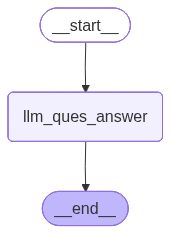

In [10]:
#to show the workflow in graphical form.
graph.compile()

In [11]:
workflow = graph.compile()

In [14]:
inital_state = QuestionAnswer(question="how far is moon from the earth")

result = workflow.invoke(inital_state)
result

{'question': 'how far is moon from the earth',
 'answer': " The average distance from the Earth to the Moon is approximately 238,855 miles (383,400 kilometers). This distance varies slightly due to the elliptical shape of the Moon's orbit around the Earth, with the Moon being closest (perigee) at about 225,623 miles (363,104 kilometers) and farthest (apogee) at about 252,088 miles (405,696 kilometers)."}

In [15]:
result['answer']

" The average distance from the Earth to the Moon is approximately 238,855 miles (383,400 kilometers). This distance varies slightly due to the elliptical shape of the Moon's orbit around the Earth, with the Moon being closest (perigee) at about 225,623 miles (363,104 kilometers) and farthest (apogee) at about 252,088 miles (405,696 kilometers)."